In [1]:
import sys

sys.path.append("../berries")


In [2]:
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

from datasets import load_dataset
cache_dir="$HOME/.cache/huggingface/datasets"
mnist = load_dataset("mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
#mnist = load_dataset("fashion_mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
mnistData = mnist['train']

X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
y_test = mnist["test"]["label"]
n_samples, _, _  = X_img.shape
X_train = X_img.reshape((n_samples, 1, 28, 28))
X_test = X_img_test.reshape((n_test_samples, 1, 28, 28))
n_channels = 1
d_x = (28, 28)
d_y = len(set(y.tolist()))

In [3]:
n_test_samples = X_test.shape[0]

In [7]:
d_channels = 1024

d_encode_hidden = 128

from jax.numpy import meshgrid, arange
pos_x1, pos_x2 = meshgrid(arange(d_x[0]), arange(d_x[1]))
pos_x1 = pos_x1.flatten()

pos_x2 = pos_x2.flatten()


x:
    a:
        1.0
    0:
        array shape: (128, 3)
    1:
        array shape: (1024, 128)
    total params: 131457
y:
    array shape: (1024, 10)
total params: 141697

accuracy: 0.14999999105930328
1.0121123


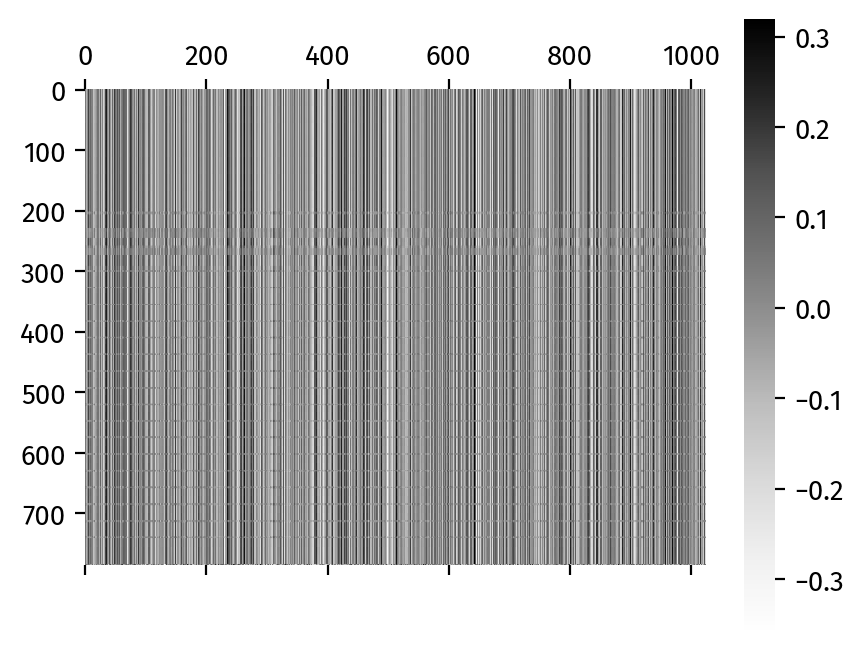

In [8]:
from jax.numpy import array, exp, mean, r_, arange, triu_indices_from
from jax.numpy.linalg import norm
from jax import grad, jit
import nn
import importlib
importlib.reload(nn)
import pf
importlib.reload(pf)
from nn import mglu_net_config, mglu_net, sglu, sglu_config
from nn import init_weights, fmt_weights
from pf import F, _
import optax

pos_dim = 0

def gaussian_activation(a, x):
    return exp((-0.5 * x ** 2) / a ** 2)

def input_encode(W, x):
    l1 = W['0'] @ x
    a = W['a']
    a1 = gaussian_activation(a, l1)
    return W['1'] @ a1

def pos_encode(W, x1, x2, v):
    rep = array([x1, x2, v])
    return input_encode(W, rep)


def input_encode_config(in_channels, init):
    return {
        'a': {
            "size": (d_encode_hidden,),
            "const": 1.0
        },
        '0': {
            "size": ( d_encode_hidden, in_channels),
            "init": init
        },
        '1': {
            "size": (d_channels, d_encode_hidden),
            "init": init
        }
    }

def mixer_head(W, x, y):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    h_y = W['y'][:, y]
    return r_[h_x, h_y[None, :]]

def mixer_head_config(init):
    return {
        'x': input_encode_config(3, init),
        'y': {
            "size": (d_channels, d_y),
            "init": {"type": "normal", "std": 0.1}
        } 
    }


def mean_loss_eu(X):
    X_mean = mean(X, axis=pos_dim)
    return mean((X - X_mean) ** 2)

def mean_loss_cos(X):
    X_mean = mean(X, axis=pos_dim)
    return optax.cosine_distance(X, X_mean)

# X: (pos_dim, hidden_dim)
def full_loss_cos(X):
    X_norm = X / norm(X, axis=1, keepdims=True)
    X_sim = X_norm @ X_norm.T
    indices = triu_indices_from(X_sim, 1)
    return mean(1 - X_sim[indices]) 

def loss_cos_classify(X):
    X_norm = X / norm(X, axis=1, keepdims=True)
    X_sim = X_norm[:-1, :] @ X_norm[-1, :]
    return mean(1 - X_sim)

def loss_cos_classify_contrastive(Wy, X):
    X_norm = X / norm(X, axis=1, keepdims=True)
    X_sim = X_norm[:-1, :] @ X_norm[-1, :]
    X_sim_neg = X_norm[:-1, :] @ Wy
    return 2 * mean(1 - X_sim) - mean(1 - X_sim_neg)




def predict_eu(W, x):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    h_X = mean(h_x, axis=pos_dim)[:, None]
    h_y_all = W['y']
    dist = mean((h_y_all - h_X[:, None]) ** 2, axis=1)
    return dist.argmin()

def predict_cos(W, x):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    #h_X = mean(h_x, axis=pos_dim)[:, None]
    h_y_all = W['y']
    h_y_all_norm = h_y_all / norm(h_y_all, axis=0, keepdims=True)
    h_X_norm = h_x / norm(h_x, axis=0, keepdims=True)
    dist = mean(1 - h_y_all_norm.T @ h_X_norm.T, axis=-1)
    return dist.argmin()

    


# method = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}

W = init_weights(next(key_gen), mixer_head_config(method))
print(fmt_weights(W)[0])
# mean_loss = F(full_loss_cos)
mean_loss = F(loss_cos_classify_contrastive)
predict = F(predict_cos)

@F
def loss1(W, X, y):
    Xs = mixer_head(W, X, y)
    return loss_cos_classify_contrastive(W['y'], Xs)

#loss1 = F(mixer_head) >> mean_loss

loss_batch = loss1.vmap((None, 0, 0), 0) >> mean

pred_batch = F(predict).vmap((None, 0), 0)

@jit
def accuracy(W, X, y):
    return mean(pred_batch(W, X) == y)

from plot_utils import visualize_matrix
from IPython.display import display

visualize_matrix(mixer_head(W, X_test[0, :], y_test[0]), dpi=200)

acc = accuracy(W, X_test[:100, :], y_test[:100])
print(f"accuracy: {acc}")


loss0 = loss_batch(W, X_test[:100, :], y_test[:100])
print(loss0)


In [13]:
import optax
from jax.tree_util import tree_map
import init_utils

import math, random
import jax.numpy as np



batch_size = 128

@jit
def get_accuracy_b_t(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        acc_all = accuracy(W, X_test[i:i + batch_size, :], y_test[i:i + batch_size])
        val +=  mean(acc_all) * real_batch_size
        n += real_batch_size
    return val / n

@jit
def loss_b_dt(W):
    batch_size_use = batch_size // 4
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size_use):
        real_batch_size = min(n_test_samples - i, batch_size_use)
        val += mean(loss_batch(W, X_test[i:i + batch_size_use, :], y_test[i:i + batch_size_use])) * real_batch_size
        n += real_batch_size
    return val / n



def sample():
    index = random.sample(range(n_samples), batch_size)
    return X_train[index, :], y[array(index)]



lr = 0.0001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.adam(lr), mask_fn)
state = opt.init(W)
state_x = opt.init(W['x'])
state_y = opt.init(W['y'])

# method = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}

W0 = W = init_weights(next(key_gen), mixer_head_config(method))


@jit
def update(W, x, y, opt_state):
    grads = grad(loss_batch)(W, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

def loss_sep_x(Wx, Wy, x, y):
    return loss_batch({"x": Wx, "y": Wy}, x, y)

def loss_sep_y(Wy, Wx, x, y):
    return loss_batch({"x": Wx, "y": Wy}, x, y)

@jit
def update_x(W, x, y, opt_state):
    grads = grad(loss_sep_x)(W['x'], W['y'], x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_Wx = optax.apply_updates(W['x'], updates)
    return {'x': new_Wx, 'y': W['y']}, opt_state

@jit
def update_y(W, x, y, opt_state):
    grads = grad(loss_sep_y)(W['y'], W['x'], x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_Wy = optax.apply_updates(W['y'], updates)
    return {'x': W['x'], 'y': new_Wy}, opt_state

In [22]:
from collections import Counter
for i in range(500000):
    xx, yy = sample()
    W, state = update(W, xx, yy, state)
    # W, state_x = update_x(W, xx, yy, state_x)
    # W, state_y = update_y(W, xx, yy, state_y)
    if i < 10 or i % 20000 == 0:
        out = jit(pred_batch)(W, xx)
        print(f"---Iter {i}---")
        print(Counter(out.tolist()))
        print(mean(accuracy(W, xx, yy)))
        print(get_accuracy_b_t(W))
        #print(loss_b_dt(W))


# print(loss_b_dt(W))


---Iter 0---
Counter({8: 128})
0.078125
0.097399995
---Iter 1---
Counter({8: 128})
0.109375
0.097399995
---Iter 2---
Counter({8: 128})
0.0703125
0.097399995
---Iter 3---
Counter({8: 128})
0.09375
0.097399995
---Iter 4---
Counter({8: 128})
0.125
0.097399995
---Iter 5---
Counter({8: 128})
0.09375
0.097399995
---Iter 6---
Counter({8: 128})
0.109375
0.097399995
---Iter 7---
Counter({8: 128})
0.09375
0.097399995
---Iter 8---
Counter({8: 128})
0.09375
0.097399995
---Iter 9---
Counter({8: 128})
0.09375
0.097399995
---Iter 20000---
Counter({1: 128})
0.140625
0.1135
---Iter 40000---
Counter({1: 128})
0.1171875
0.1135
---Iter 60000---
Counter({8: 126, 1: 2})
0.078125
0.0932
---Iter 80000---
Counter({8: 109, 1: 19})
0.0859375
0.080299996
---Iter 100000---
Counter({8: 128})
0.0859375
0.0975
---Iter 120000---
Counter({1: 128})
0.09375
0.1135
---Iter 140000---
Counter({1: 128})
0.078125
0.1134
---Iter 160000---
Counter({1: 111, 8: 17})
0.0625
0.0764
---Iter 180000---
Counter({1: 102, 8: 26})
0.04687

In [13]:
W0 = W

In [23]:
from sklearn.manifold import TSNE

from jax.numpy import vstack
import matplotlib.pyplot as plt

yd = W['y']
xyd1 = mixer_head(W, X_test[0, :], y_test[0])
xyd2 = mixer_head(W0, X_test[0, :], y_test[0])
xyd3 = mixer_head(W, X_test[1, :], y_test[1])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100).fit_transform(vstack([xyd1, xyd3, yd.T]))

# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                     init='random', perplexity=3).fit_transform(vstack([yd.T, mixer_head(W, xx[0, :], yy[0]), mixer_head(W, xx[1, :], yy[1])]))

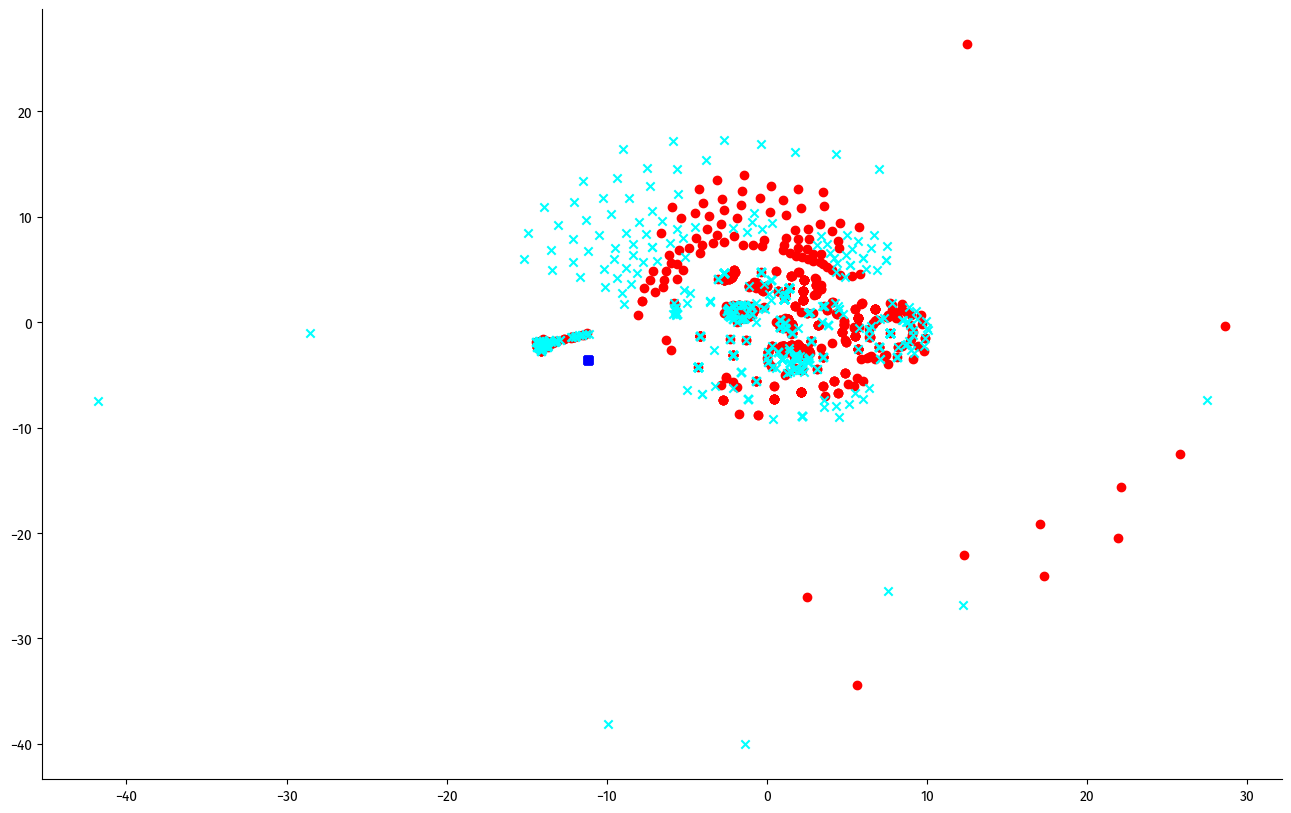

(1580, 2)


In [24]:

plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:784, 0], X_embedded[:784, 1], c='r')
# plt.scatter(X_embedded[785:2*784+1, 0], X_embedded[785: 2*784+1, 1], c='pink')
#plt.scatter(X_embedded[2*784+1: -10, 0], X_embedded[ 2*784+1: -10, 1], c='blue')
plt.scatter(X_embedded[785: -10, 0], X_embedded[785: -10, 1], c='cyan', marker='x')
plt.scatter(X_embedded[-10:, 0], X_embedded[-10:, 1], c='blue', marker='s')
plt.show()
print(X_embedded.shape)

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7b700c38b3a0>)

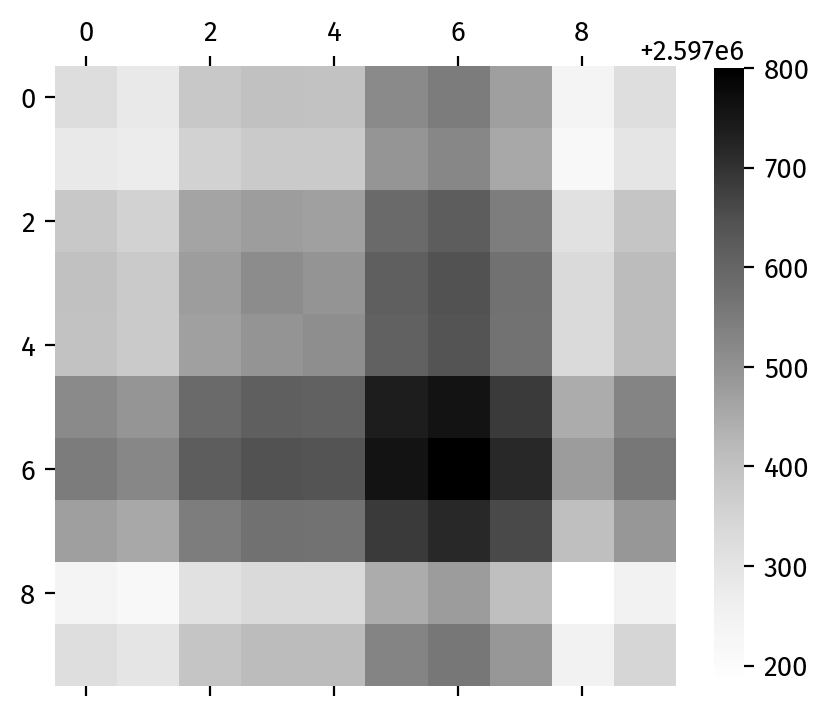

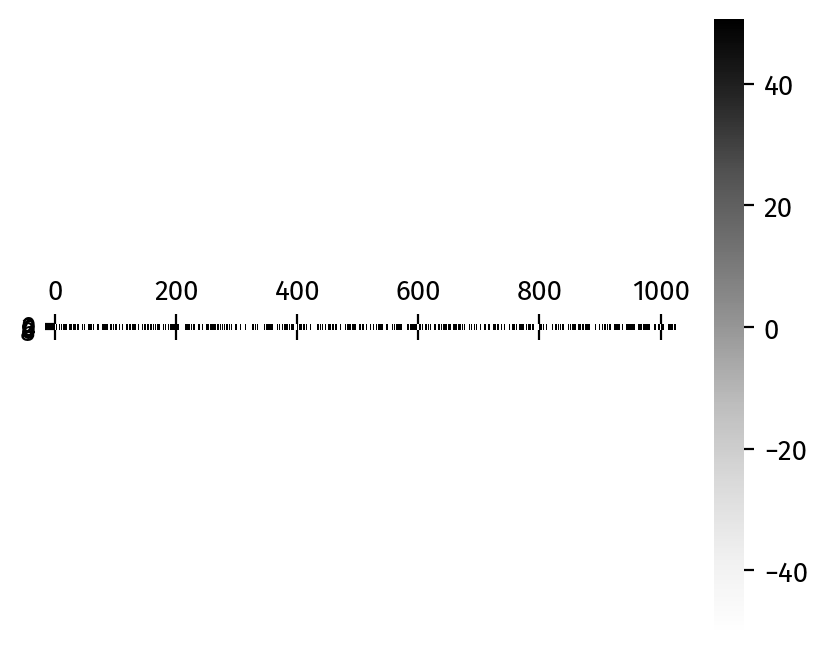

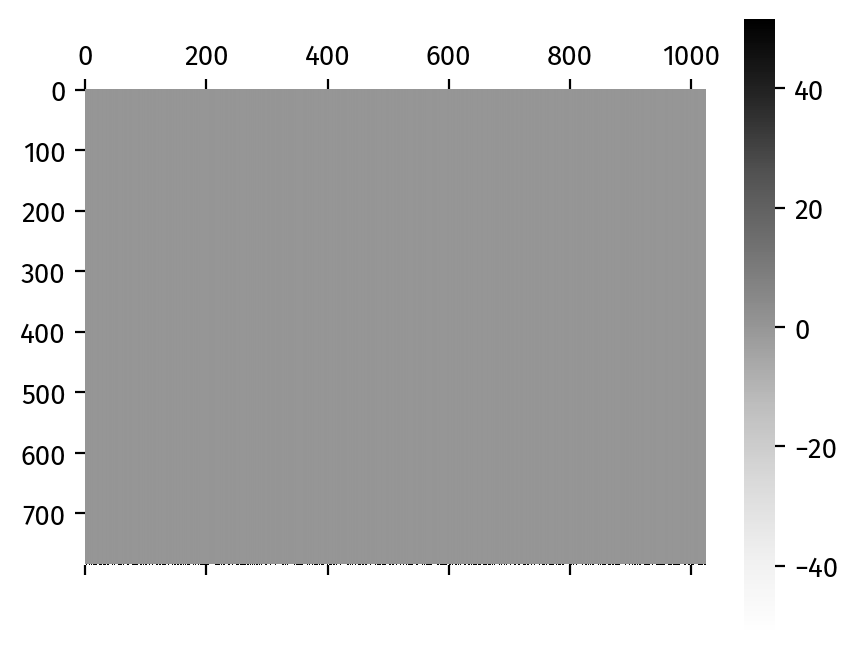

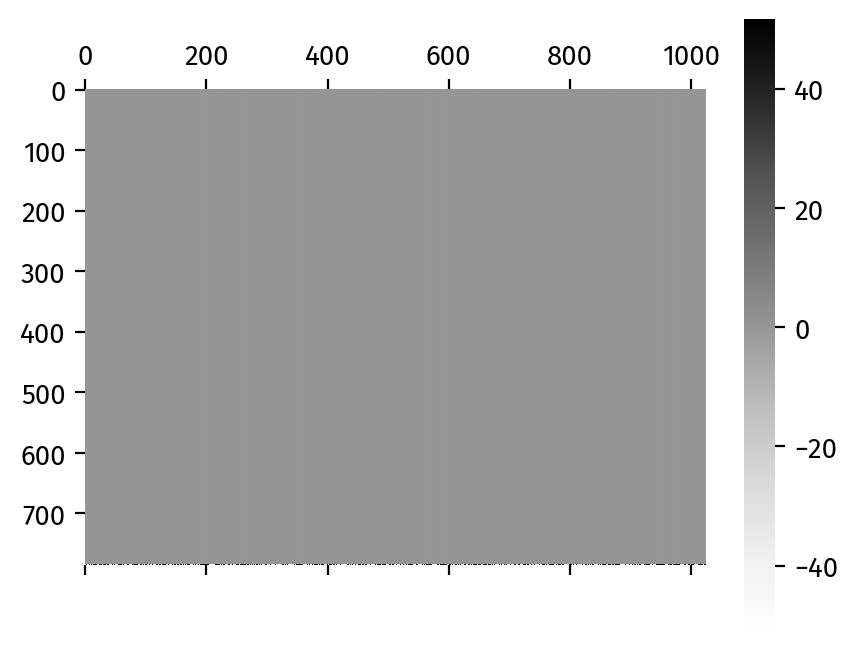

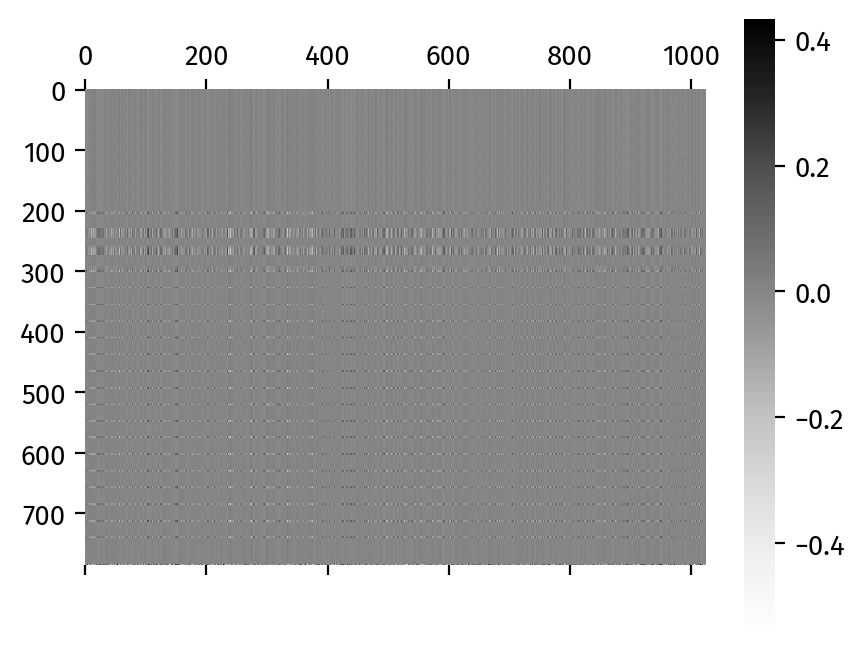

In [25]:
visualize_matrix(yd.T @ yd, dpi=200)
visualize_matrix(yd.T, dpi=200)
visualize_matrix(xyd1 - mean(xyd1, axis=0), dpi=200)
visualize_matrix(xyd3 - mean(xyd3, axis=0), dpi=200)
visualize_matrix(xyd2 - mean(xyd2, axis=0), dpi=200)